# Rapport: SAÉ 2.04

## 1 - Introduction

Ce notebook vise à générer et analyser des cartes de contrôle à partir de données de capteurs d'une machine industrielle.
- Générer des cartes de contrôle pour évaluer la qualité des capteurs.
- Détecter les pannes potentielles à l'aide de règles basées sur des tests statistiques.
- Étendre la base de données pour effectuer des statistiques sur le taux de pannes des capteurs

### 1.1 - Plan du rapport

- 1 - Introduction
    - 1.1 - Plan du rapport
- 2 - Importation des bibliothèques et configuration
- 3 - Cartes de contrôle
    - 3.1 - Explication des fonctions Python et requêtes SQL
        - 3.1.1 - Fonction getLastMeasure
        - 3.1.2 - Fonction getDataControlCard
        - 3.1.3 - Fonction getAvgAndStddevErrorValue
        - 3.1.4 - Fonction showControlCard
    - 3.2 Code Python
    - 3.3 Carte de contrôle
- 4 - Visualisation des marges d'erreur
    - 4.1 - Explication des fonctions Python et requêtes SQL
        - 4.1.1 - Fonction getErrorValues
        - 4.1.2 - Fonction getAverageFromData
        - 4.1.3 - Fonction getStddevFromData
        - 4.1.4 - Fonction getDistributionByStdIntervals
        - 4.1.5 - Fonction getPercentageInterval
        - 4.1.6 - Fonction showDistribution
    - 4.2 - Code Python
    - 4.3 - Histogramme des répartitions
    - 4.4 - Réponses aux questions
    - 4.5 - Alternative pour répondre aux questions
- 5 - p-valeur
    - 5.1 - Explication des fonctions Python
        - 5.1.1 - Fonction pExactlyKPointOutOfN
        - 5.1.2 - Fonction pAtLeastKPointOutOfN
    - 5.2 - Code Python
    - 5.3 - Réponses aux questions
    - 5.4 - Implémentation des règles
        - 5.4.1 - Fonction kPointOnTheLastNOnTheSameSide
        - 5.4.2 - Fonction kPointOnTheLastNOutsideInverval
        - 5.4.3 - Code Python et implémentation des règles
    - 5.5 - Proposition et implémentation d'une règle de détection de défaillance
        - 5.5.1 - Proposition et calcul de la pvaleur de la règle
        - 5.5.2 - Code Python de l'implémentation
- 6 - Dérive et régression
    - 6.1 - Explication des fonctions Python
        - 6.1.1 - Fonction covariance
        - 6.1.2 - Fonction regressionLine
        - 6.1.3 - Fonction showControlCardWithRegressionLine
    - 6.2 - Code Python
    - 6.3 - Carte de contrôle avec droite de régression

## 2 - Importation des bibliothèques et configuration

Le code ci-dessous permet d'importer les bibliothèques utilisées dans le projet, configurer la connexion à la base de données et également choisir le capteur qui sera étudié.

La variable `id_sensor` est une constante permettant de sélectionner le capteur étudié.

In [77]:
import psycopg
import matplotlib.pyplot as plt
import numpy
from datetime import timedelta, datetime
import math

plt.style.use('seaborn-v0_8')

# Connexion settings
conn_settings = {
  "host": "localhost",
  "dbname": "db",
  "user": "postgres",
  "password": "patate360",
  "port": 5432
}

conn = psycopg.connect(**conn_settings)

id_sensor = 3 # Constant to select the sensor

# Check if the sensor exists in the database
sql = """
SELECT * FROM Sensor WHERE sensorid = %(id)s 
"""

param = {"id": id_sensor}

with conn.execute(sql, param) as cur:
  row = cur.fetchone()
  if(row == None):
    raise Exception("No sensor associated with this id")

## 3 - Cartes de contrôle

Cette section correspond à la partie **1 - Cartes de contrôle** du sujet de la SAÉ.
L'objectif est de générer une carte de contrôle pour le capteur sélectionné, sur celle-ci on doit retrouver:
- La courbe de l'évolution de la **valeur d'erreur** (différence entre la valeur mesurée manuellement et automatiquement) dans le temps, pour les 8 derniers jours avec un maximum de 100 points et au minimum 20 points (pouvant étendre la plage des 8 derniers jours).
- La moyenne *µ* de la valeur d'erreur sur l'ensemble des points de la base de données pour le capteur choisi
- La **limite de contrôle supérieure** (ou **UCL** pour *Upper Control Limit*) calculée avec la formule: $µ + 2σ$
- La **limite de contrôle inférieur** (ou **LCL** pour *Lower Control Limit*) calculée avec la formule: $µ - 2σ$

$[UCL, LCL]$ représente l'intervalle de confiance dans lequel les valeurs d'erreur doivent se trouver.

### 3.1 - Explication des fonctions Python et requêtes SQL

#### 3.1.1 - Fonction getLastMeasure

Cette fonction permet de retourner la date et l'heure de la dernière mesure effectuée sur le capteur sélectionné.

Elle utilise la requête SQL suivante:

```sql
SELECT max(controltimestamp) 
FROM controlMeasurement
WHERE sensorid = %(id)s 
```

Cette requête récupère les lignes de la table `ControlMeasurement`, applique une **restriction** sur `sensorid` pour travailler seulement sur les lignes du capteur concerné et utilise la **fonction d'agrégat** `MAX` sur la colonne `controlTimestamp` dans la **projection** pour identifier le timestamp le plus récent.

#### 3.1.2 - Fonction getDataControlCard

Cette fonction permet de retourner les valeurs d'erreur affichées sur la carte de contrôle.

Elle utilise la requête SQL suivante:

```sql
SELECT controlValue - sensorValue, controltimestamp
FROM ControlMeasurement cm
JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
WHERE cm.sensorid = %(id)s
ORDER BY controltimestamp DESC
LIMIT 100
```

Cette requête effectue une **jointure interne** entre les tables `ControlMeasurement` et `SensorMeasurement` pour récupérer la mesure manuelle associée à la mesure automatique. Une **restriction** est appliquée sur `sensorid` pour ne conserver que les données liées au capteur spécifié. La **projection** calcule la valeur de l'erreur tout en incluant `controlTimestamp`. Les résultats sont triés par ordre décroissant de `controlTimestamp` et limités aux 100 premières lignes pour obtenir les 100 dernières valeurs d'erreur.

Pour respecter la contrainte de n'afficher qu'au minimum 20 points sur la carte de contrôle, on utilise la condition d'arrêt suivante en Python pour itéré sur les résultats de notre requête:

```python
line != None and (line[1] >= limit_days or len(rows) < 20)
```

- `line` est la ligne actuelle à traiter de la requête, on vérifie que celle-ci n'est pas None pour éviter de déclencher une exception dans notre code si la base ne contient pas assez de données.
- `line[1]` est le timestamp de la mesure manuelle effectuée et `limit_days` la date de la dernière mesure à laquelle on a soustrait 8 jours. On vérifie que `line[1]` est supérieur ou égal à `limit_days` pour respecter l'intervalle des 8 derniers jours.
- `rows` est le tableau qui contient les valeurs de sortie de la fonction, si elle ne contient pas au minimum 20 éléments, on continue d'itérer sur les données même si le `line[1]` est inférieur à `limit_days`.

#### 3.1.3 - Fonction getAvgAndStddevErrorValue

Cette fonction permet de retourner la moyenne et l'écart-type de la valeur de l'erreur pour le capteur sélectionné.

Elle utilise la requête SQL suivante:

```sql
SELECT avg(controlValue - sensorValue), stddev(controlValue - sensorValue)
FROM ControlMeasurement cm
JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
WHERE cm.sensorid = %(id)s;
```

Cette requête effectue une **jointure interne** entre les tables `ControlMeasurement` et `SensorMeasurement` pour récupérer la mesure manuelle associée à la mesure automatique. Une **restriction** est appliquée sur `sensorid` pour ne conserver que les données liées au capteur spécifié. Les **fonctions d'agrégat** `AVG` et `STDDEV` dans la **projection** calcule respectivement la moyenne et l'écart-type de la valeur de l'erreur.

#### 3.1.4 - Fonction showControlCard

Cette fonction affiche la carte de contrôle en utilisant matplotlib

Elle est séparée en 4 sections:
- La récupération des données, en utilisant les fonctions précédentes.
- Le formatage des données au bon format pour tracer la courbe
- Le traçage des différentes courbes
- Les ajustements visuels du rendu

### 3.2 Code Python

In [78]:
"""
Get the last manual measurement for the selected sensor

:return: datetime with the last measure
"""
def getLastMeasure()->datetime: 
  sql = """
  SELECT max(controltimestamp)
  FROM controlMeasurement
  WHERE sensorid = %(id)s
  """

  param = {"id": id_sensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

"""
Get the error values for the last 8 days up to a limit of 100 items, 
and if the number of items is less than 20, extend the period bayond 8 days.
Each error value is associated with the time the measurements were made

:return: list[tuple[float, datetime]] Each tuple contains the erreur value and the timestamp corresponding to the measurement time
"""
def getDataControlCard()->list[tuple[float, datetime]]: 
  # Used to retrieve values within an 8 days interval from the last measurement
  limit_days = getLastMeasure() - timedelta(days = 8)

  sql = """
  SELECT controlValue - sensorValue, controltimestamp
  FROM ControlMeasurement cm
  JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
  WHERE cm.sensorid = %(id)s
  ORDER BY controltimestamp DESC
  LIMIT 100
  """

  param = {"id": id_sensor}

  with conn.execute(sql, param) as cur:
    rows = []
    line = cur.fetchone()
    
    # Guarantee at least 20 points, even if the last 8 days don't have enough data
    while(line != None and (line[1] >= limit_days or len(rows) < 20)):
      rows.append(line)
      line = cur.fetchone()

    # Reverse the list to have the data in the correct order
    rows.reverse()
    return rows

"""
Get the average and stddev of the erreur values

:return: tuple[float, float] where tuple[0] is avg and tuple[1] is stddev
"""
def getAvgAndStddevErrorValue()->tuple[float, float]:
  sql = """
    SELECT avg(controlValue - sensorValue), stddev(controlValue - sensorValue)
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s;
  """

  param = {"id": id_sensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()

"""
Show control chart
""" 
def showControlCard()->None:
  # Get data needed for display
  data = getDataControlCard()
  avg, stddev = getAvgAndStddevErrorValue()

  # Format the data
  x = []
  y = []
  for el in data:
    y.append(el[0])
    x.append(el[1])

  # Show Data
  plt.figure(figsize=(12, 8))
  plt.plot(x, y, label='Error values', marker='o')
  plt.plot([data[0][1], data[-1][1]], [avg, avg], label='Average')
  plt.plot([data[0][1], data[-1][1]], [avg + 2 * stddev, avg + 2 * stddev], c="Red", lw=2, ls='--' , label='Upper Control Limit')
  plt.plot([data[0][1], data[-1][1]], [avg - 2 * stddev, avg - 2 * stddev], c="Black", lw=2, ls='--', label='Lower Control Limit')
  
  # Visualization Enhancements
  plt.title('Control Chart Sensor #' + str(id_sensor))
  plt.xlabel('Time')
  plt.ylabel('Error measurement')
  plt.legend(bbox_to_anchor=(1, 1)) # Place the legend outside the chart
  plt.xticks(rotation=30) # For better readability

### 3.3 - Carte de contrôle

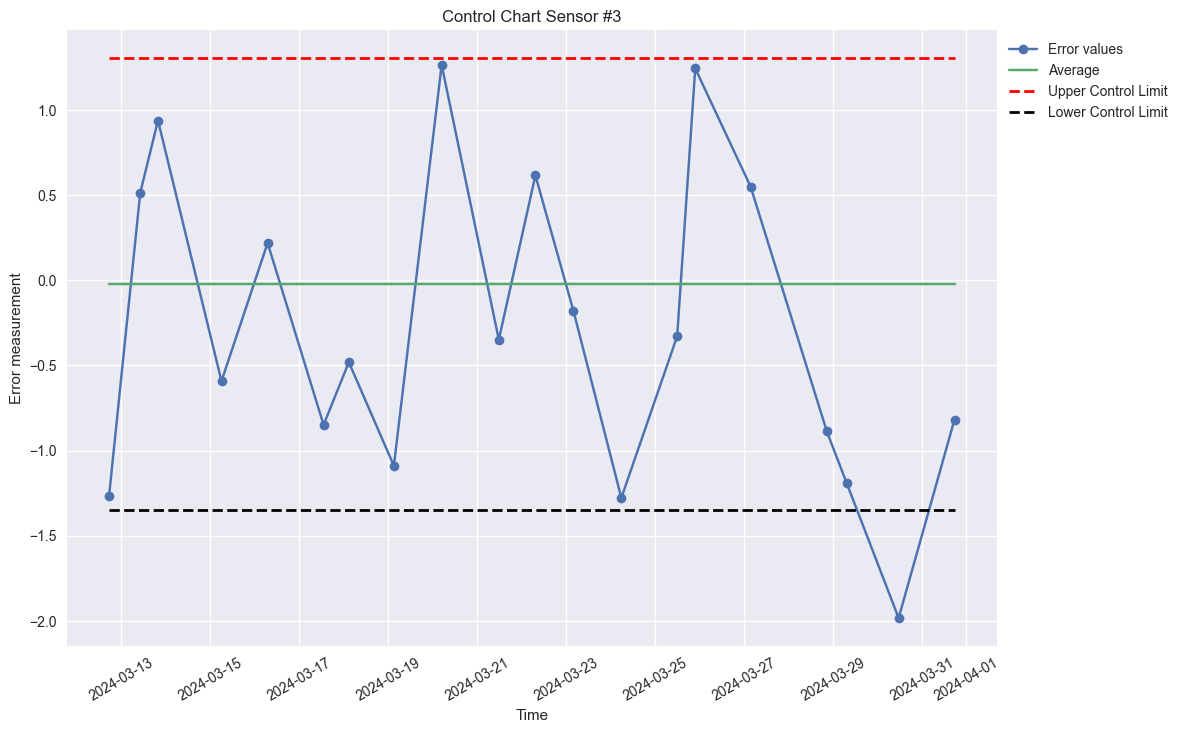

In [79]:
showControlCard()

## 4 - Visualisation des marges d'erreur

### 4.1 - Explication des fonctions Python et requêtes SQL

#### 4.1.1 - Fonction getErrorValues

Cette fonction permet de retourner l'ensemble des valeurs d'erreur pour un capteur.

Elle utilise la requête SQL suivante:

```sql
SELECT controlValue - sensorValue
FROM ControlMeasurement cm
JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
WHERE cm.sensorid = %(id)s
```

Cette requête effectue une **jointure interne** entre les tables `ControlMeasurement` et `SensorMeasurement` pour récupérer la mesure manuelle associée à la mesure automatique. Une **restriction** est appliquée sur `sensorid` pour ne conserver que les données liées au capteur spécifié. La **projection** calcule la valeur de l'erreur.

#### 4.1.2 - Fonction getAverageFromData

Cette fonction calcule la moyenne d'un ensemble de données passé en paramètre.

Pour le calcul, elle applique la formule suivante: $\bar{x} = \frac{1}{n} \displaystyle\sum_{i=1}^n x_{i}$

#### 4.1.3 - Fonction getStddevFromData

Cette fonction calcule l'écart-type d'un ensemble de données passé en paramètre.

Pour le calcul, elle applique la formule suivante: $\sigma = \sqrt{ \frac{1}{n} \displaystyle\sum_{i=1}^n (x_{i}-\bar{x})^2 } $

Où $\bar{x}$ représente la moyenne calculée avec la fonction `getAverageFromData`.

#### 4.1.4 - Fonction getDistributionByStdIntervals

Cette fonction calcule la distribution des valeurs d'un ensemble de données en fonction d'intervalles définis par des multiples de l'écart-type.
Elle prend en paramètre les données `data` et un multiplicateur `factor`.

`factor` permet de définir le plus grand multiplicateur de l'écart-type qui sert à créer les intervalles.

La fonction commence par initialiser une liste de compteur `counts`, chacun a zéro.

La liste est organisée comme suit:
$([-\sigma, 0], \; ]0, \sigma], \; \dots, \; [-\text{factor} \cdot \sigma, -(\text{factor} - 1) \cdot \sigma[, \; ](\text{factor} - 1) \cdot \sigma, \text{factor} \cdot \sigma], \; < -\text{factor} \cdot \sigma, \; > \text{factor} \cdot \sigma)$

Avec `factor` = 3, on aurait la liste de compteur suivante: $([-\sigma, 0], \; ]0, \sigma], \; [-2 \cdot \sigma, - \sigma[, \; ]\sigma, 2 \cdot \sigma], \; [-3 \cdot \sigma, -2 \cdot \sigma[, \; ]2 \cdot \sigma, 3 \cdot \sigma], \; < -3 \cdot \sigma, \; > 3 \cdot \sigma)$

Elle itère sur chaque valeur de l'ensemble des données, à chaque itération elle calcule la division entière de la valeur absolue par l'écart-type qui est stockée dans la variable `interval_index`. Etant donné que les compteurs sont organisés par paire, si notre valeur est négative ou nulle, l'indice dans la liste est $interval\_index \times 2$ sinon il est $interval\_index \times 2 + 1$.

Dans le cas où une valeur est un multiple de l'écart-type, on applique une correction sur `interval_index` en lui soustrayant 1, cela permet de garder nos intervalles inclusifs.

Dans le cas où `interval_index` est supérieur ou égal à `facteur`, cela signifie que la valeur est hors de l'intervalle $[-\text{factor} \cdot \sigma, \text{factor} \cdot \sigma]$ et sera donc comptabilisée dans le compteur $< -\text{factor} \cdot \sigma$ ou $> \text{factor} \cdot \sigma$ en fonction de si elle est négative ou positive.

A la fin, la fonction réorganise les résultats pour qu'ils soient exploitables plus facilement, elle va également calculer les proportions par rapport au nombre de données total.

Le résultat final est organisé comme suit:
$(< -\text{factor} \cdot \sigma, \; [-\text{factor} \cdot \sigma, -(\text{factor} - 1) \cdot \sigma[, \; \dots, \; [-\sigma, 0], \; ]0, \sigma], \; \dots, \; ](\text{factor} - 1) \cdot \sigma, \text{factor} \cdot \sigma], \; > \text{factor} \cdot \sigma)$

Dans la théorie, la somme des valeurs stockées dans la liste renvoyée par cette fonction est 1. Dans les faits, il peut y avoir des erreurs d'arrondi dues au fonctionnement interne des nombres à virgule flottante, mais le résultat de cette somme sera dans tous les cas très proche de 1.

#### 4.1.5 - Fonction getPercentageInterval

Cette fonction calcule le pourcentage des valeurs qui sont incluses et exclues de l'intervalle défini par $[-\text{factor} \cdot \sigma, \text{factor} \cdot \sigma]$.

Elle prend en paramètre la liste des distributions générée par la fonction `getDistributionByStdIntervals` et un entier `factor` pour définir l'intervalle.

Étant donné la structure des données renvoyées par la fonction `getDistributionByStdIntervals`, il est assez facile de trouver l'indice correspondant au début et à la fin de l'intervalle.

La fonction effectue simplement la somme des valeurs comprises entre l'indice de départ et de fin, qui correspond donc aux valeurs comprises dans l'intervalle.
Pour obtenir la proportion de valeurs exclues de l'intervalle, elle soustrait cette somme à 1.

#### 4.1.6 - Fonction showDistribution

Cette fonction affiche la distribution des valeurs d'erreur d'un capteur en utilisant matplotlib.

Elle prend en paramètre un ensemble de données et un entier `factor` représentant l'intervalle étudié.

Elle est séparée en 5 sections:
- La récupération de la distribution, et la conversion de celle-ci en pourcentage
- La génération des étiquettes affichée sur l'axe X
- Le traçage de l'histogramme
- L'affichage des pourcentages au-dessus des différentes barres
- La gestion des différentes étiquettes, titres, etc

### 4.2 - Code Python

In [80]:
"""
Get error values from the database

:return: list[float]
"""
def getErrorValues()->list[float]:
  sql = """
    SELECT controlValue - sensorValue
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s
  """

  param = {"id": id_sensor}

  with conn.execute(sql, param) as cur:
    return [row[0] for row in cur]
  
"""
Calculate the average of the input data

:data: list[float]

:return: float
"""
def getAverageFromData(data:list[float])->float:
  sum = 0

  for value in data:
    sum += value

  return sum / len(data)

"""
Calculate the standard deviation of the input data

:data: list[float]

:return: float
"""
def getStddevFromData(data:list[float])->float:
  avg = getAverageFromData(data)
  sum = 0

  for value in data:
    sum += (value - avg) ** 2

  return (sum / len(data)) ** 0.5

"""
Calculate the distribution of values in a data set based on intervals defined by multiples of the standard deviation.

:data: list[float]
:factor: int, maximum factor of the standard deviation to study

:return: list[float]
"""
def getDistributionByStdIntervals(data:list[float], factor:int)->list[float]:
  # Initialize a list of counters. The indexes correspond to intervals defined by multiples of the standard deviation.
  # The structure is organized as follows:
  # [ [-σ; 0], ]0; σ], ...,  [-factor*σ; -(factor-1)*σ[, ](factor-1)*σ; factor*σ], < -factor*σ, > factor*σ ]
  counts = [0 for _ in range(factor * 2 + 2)]

  std_dev = getStddevFromData(data)

  # Loops through the data values to distribute them into the corresponding intervals.
  for value in data:
    # Determines the index of the interval corresponding to the value based on the standard deviation.
    # The interval is calculated by taking the absolute value divided by the standard deviation.
    interval_index = int(abs(value) // (std_dev))
    # Corrects the index to avoid errors due to exact divisions (if the value is a multiple of the standard deviation).
    if(abs(value) % std_dev == 0 and value != 0):
      interval_index -= 1

    # Updates the counter corresponding to the interval.
    # If the index exceeds the limit define by "factor", increment the counter of out-of-bounds values.
    if (interval_index >= factor):
      counts[-1 if value > 0 else -2] += 1
    else:
      counts[interval_index * 2 + (1 if value > 0 else 0)] += 1

  # Organize the results in the following order:
  # [< -factor*σ, [-factor*σ; -(factor-1)*σ[, ..., [-σ; 0], ]0; σ], ..., ](factor-1)*σ; factor*σ], > factor*σ]
  result = []
  for i in range(len(counts) - 2, -1, -2):
    result.append(counts[i] / len(data))
  for i in range(1, len(counts), 2):
    result.append(counts[i] / len(data))

  return result

"""
Return the percentage of value included and excluded from the interval [-factor*σ; factor*σ] 

:distribution: list[float], obtained with the getDistributionByStdIntervals() function
:factor: int

:return: tuple[float, float] where the first element represents the proportion of values included in the interval and the second the proportion excluded
"""
def getPercentageInterval(distribution:list[float], factor:int)->tuple[float, float]:
  if(factor <= 0):
    raise Exception("The factor must be greater than 0")
  if(factor > (len(distribution) - 2) / 2):
    raise Exception("The factor is greater than that used to generate the distribution")
  
  factor -= 1
  
  index_start = len(distribution) // 2 - 1 - factor
  index_end = len(distribution) // 2 + factor

  res = 0

  for i in range(index_start, index_end + 1, 1):
    res += distribution[i]

  return round(res * 100, 2), round((1 - res) * 100, 2)

"""
Display the histogram of data distributions

:data: list[float]
:factor: int
"""
def showDistribution(data:list[float], factor:int)->None:
  # Get the distribution of values
  distribution = getDistributionByStdIntervals(data, factor)
  distribution = [round(value * 100, 2) for value in distribution]
  x_pos = [i for i in range(len(distribution))]

  # Generate the labels
  labels = [str(-i) + 'σ' for i in range(factor, 0, -1)] + ['0'] + [str(i) + 'σ' for i in range(1, factor + 1)]

  # Build the  histogram
  plt.figure(figsize=(12, 8))
  plt.bar(x_pos, distribution, width=1, align='edge', edgecolor='black')

  # Show percentages above bars
  for i, value in enumerate(distribution):
    plt.text(i + 0.5, value + 0.2, str(value) + '%', ha='center', va='bottom')

  # Label management
  x_pos = [i for i in range(1, len(distribution))]
  plt.xticks(ticks=x_pos, labels=labels)

  plt.title("Distribution Sensor #" + str(id_sensor))
  plt.xlabel('Deviation')
  plt.ylabel('Probability')

### 4.3 - Histogramme des répartitions

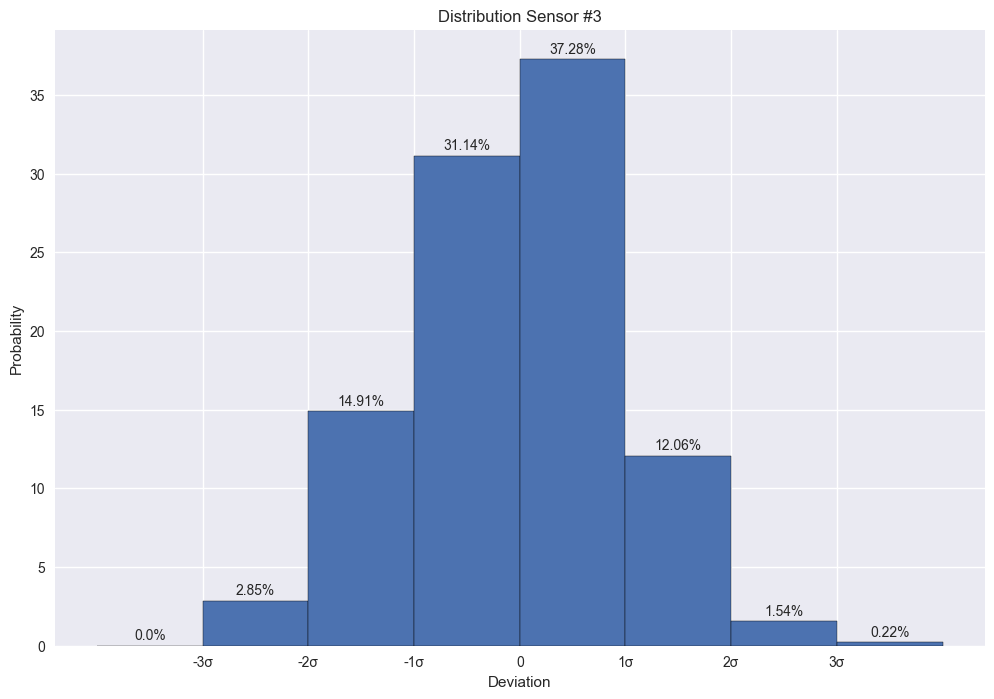

In [81]:
data = getErrorValues()
showDistribution(data, 3)

### 4.4 - Réponses aux questions

Les fonctions écrites plus haut permettent de répondre facilement aux questions 1 jusqu'à 4 dans la section "2.1 Visualisation des marges d'erreur" du sujet.

In [82]:
distribution = getDistributionByStdIntervals(data, 3)

res_q1 = getPercentageInterval(distribution, 1)
res_q2 = getPercentageInterval(distribution, 2)
res_q3 = getPercentageInterval(distribution, 3)

print("Question 2.1.1: Dans l'intervalle [-σ; σ], il y a " + str(res_q1[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervalle, il y a " + str(res_q1[1]) + "% des points\n")
print("Question 2.1.2: Dans l'intervalle [-2σ; 2σ], il y a " + str(res_q2[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervalle, il y a " + str(res_q2[1]) + "% des points\n")
print("Question 2.1.3: Dans l'intervalle [-3σ; 3σ], il y a " + str(res_q3[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervalle, il y a " + str(res_q3[1]) + "% des points\n")


Question 2.1.1: Dans l'intervalle [-σ; σ], il y a 68.42% des points
	Question 2.1.4: En dehors de cet intervalle, il y a 31.58% des points

Question 2.1.2: Dans l'intervalle [-2σ; 2σ], il y a 95.39% des points
	Question 2.1.4: En dehors de cet intervalle, il y a 4.61% des points

Question 2.1.3: Dans l'intervalle [-3σ; 3σ], il y a 99.78% des points
	Question 2.1.4: En dehors de cet intervalle, il y a 0.22% des points



### 4.5 - Alternative pour répondre aux questions

Un moyen alternatif de répondre aux questions et d'utiliser une requête SQL combinant plusieurs vues pour parvenir au résultat souhaité.

La première vue permet d'ajouter la valeur d'erreur sur chaque entrée de la table `controleMeasurement`.
Elle effectue la **jointure interne** entre `controlMeasurement` et `sensorMeasurement` pour récupérer la mesure manuelle associée à la mesure automatique. Elle calcule dans la **projection** la valeur d'erreur.

```sql
WITH errorValues AS (
    SELECT cm.*, (controlValue - sensorValue) as errorValue
    FROM controlMeasurement AS cm
    JOIN sensorMeasurement AS sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
)
```

La seconde vue permet de calculer l'écart-type de chaque capteur, elle utilise la vue précédente pour récupérer les valeurs d'erreur. L'**agrégation** sur la colonne `sensorid` permet de regrouper les lignes avec un `sensorid` commun. Dans la **projection**, on utilise la **fonction d'agrégat** `STDDEV` pour calculer l'écart-type de chaque capteur.

```sql
WITH std_devs AS (
    SELECT sensorid, STDDEV(errorValue) as stddev
    FROM errorValues
    GROUP BY sensorid
)
```

La troisième vue permet de récupérer le nombre d'entrées pour chaque capteur dans la table `controlMeasurement`. L'**agrégation** sur la colonne `sensorid` permet de regrouper les lignes avec un `sensorid` commun. Dans la **projection**, on utilise la **fonction d'agrégat** `COUNT` pour compter le nombre de lignes pour chaque capteur.

```sql
WITH totalEntry AS (
    SELECT sensorid, COUNT(*) as count
    FROM controlmeasurement
    GROUP BY sensorid
)
```

La quatrième et dernière vue utilise les trois vues précédentes pour calculer la probabilité qu'une valeur d'erreur est incluse ou exclue de l'intervalle $[\text{lb} \times \sigma, \text{ub} \times \sigma]$.
Elle effectue des **jointures internes** entre `errorValues`, `std_devs` et `totalEntry`, applique une **restriction** pour ne conserver que les valeurs comprises dans l'intervalle. Dans la **projection**, on effectue les différents calculs:

Probabilité d'être inclus dans l'intervalle: $\frac { \text{nbElementDansIntervalle} }{ \text{nbElementTotal} } \times 100$

Probabilité d'être exclus de l'intervalle: $(1 - \frac { \text{nbElementDansIntervalle} }{ \text{nbElementTotal} }) \times 100$

À noter l'utilisation de la fonction `cast`, celle-ci permet de changer le type de variable d'une colonne. La **fonction d'agrégat** `COUNT` renvoie un entier. Étant donné que l'on effectue la division entre deux entiers, le résultat était la division entière des deux nombres. Il suffisait de convertir un de nos deux opérandes pour l'éviter.

```sql
WITH probabilityRange AS (
    SELECT sensorid, cast(COUNT(*) as numeric) / count * 100 as probabilityInside, (1 - cast(COUNT(*) as numeric) / count) * 100 as probabilityOutside
    FROM errorValues
    JOIN std_devs USING(sensorid)
    JOIN totalEntry USING(sensorid)
    WHERE errorValue >= %(lb)s*stddev AND errorValue <= %(ub)s*stddev
    GROUP BY sensorid, count
)
```

La requête principale récupère les données de la vue `probabilityRange` et fait une **restriction** pour conserver seulement le capteur qui nous intéresse.

```sql
SELECT *
FROM probabilityRange
WHERE sensorid = %(id)s
```

Cette fonction a l'avantage d'être plus modulaire que sa première version, on peut par exemple demander les résultats pour les valeurs comprises entre $[-0.5 \cdot \sigma, -0.2 \cdot \sigma]$, ce qui n'était pas possible avant.

In [83]:
"""
Return the percentage of value included and excluded from the interval [lower_bound*σ; upper_bound*σ] 

:lower_bound: float
:upper_bound: float

:return: tuple[float, float] where the first element represents the proportion of values included in the interval and the second the proportion excluded
"""
def getPercentageIntervalSQL(lower_bound:float, upper_bound:float)->tuple[float, float]:
  if(lower_bound >= upper_bound):
    raise Exception("lower_bound must be smaller than upper_bound")

  sql = """
    WITH errorValues AS (
        SELECT cm.*, (controlValue - sensorValue) as errorValue
        FROM controlMeasurement AS cm
        JOIN sensorMeasurement AS sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    ),
    std_devs AS (
        SELECT sensorid, STDDEV(errorValue) as stddev
        FROM errorValues
        GROUP BY sensorid
    ),
    totalEntry AS (
        SELECT sensorid, COUNT(*) as count
        FROM controlmeasurement
        GROUP BY sensorid
    ),
    probabilityRange AS (
        SELECT sensorid, cast(COUNT(*) as numeric) / count * 100 as probabilityInside, (1 - cast(COUNT(*) as numeric) / count) * 100 as probabilityOutside
        FROM errorValues
        JOIN std_devs USING(sensorid)
        JOIN totalEntry USING(sensorid)
        WHERE errorValue >= %(lb)s*stddev AND errorValue <= %(ub)s*stddev
        GROUP BY sensorid, count
    )
    SELECT probabilityInside, probabilityOutside
    FROM probabilityRange
    WHERE sensorid = %(id)s
  """

  param = {"id": id_sensor, "lb": lower_bound, "ub": upper_bound}

  with conn.execute(sql, param) as cur:
    row = cur.fetchone()

    if(row == None):
      return -1, -1

    return round(row[0], 2), round(row[1], 2)
  
res_q1 = getPercentageIntervalSQL(-1, 1)
res_q2 = getPercentageIntervalSQL(-2, 2)
res_q3 = getPercentageIntervalSQL(-3, 3)

print("Question 2.1.1: Dans l'intervalle [-σ; σ], il y a " + str(res_q1[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervalle, il y a " + str(res_q1[1]) + "% des points\n")
print("Question 2.1.2: Dans l'intervalle [-2σ; 2σ], il y a " + str(res_q2[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervalle, il y a " + str(res_q2[1]) + "% des points\n")
print("Question 2.1.3: Dans l'intervalle [-3σ; 3σ], il y a " + str(res_q3[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervalle, il y a " + str(res_q3[1]) + "% des points\n")

Question 2.1.1: Dans l'intervalle [-σ; σ], il y a 68.42% des points
	Question 2.1.4: En dehors de cet intervalle, il y a 31.58% des points

Question 2.1.2: Dans l'intervalle [-2σ; 2σ], il y a 95.39% des points
	Question 2.1.4: En dehors de cet intervalle, il y a 4.61% des points

Question 2.1.3: Dans l'intervalle [-3σ; 3σ], il y a 99.78% des points
	Question 2.1.4: En dehors de cet intervalle, il y a 0.22% des points



## 5 - p-valeur

### 5.1 - Explication des fonctions Python

#### 5.1.1 - Fonction pExactlyKPointOutOfN

Cette fonction calcule la probabilité qu'un événement avec une probabilité $p$ se produise exactement $k$ fois parmi $n$ essais.

Elle utilise la formule suivante: $P(X = k) = \binom{n}{k} p^k (1-p)^{n-k}$

Où $\binom{n}{k}$ représente le coefficient binomial, celui-ci représente le nombre de façons de choisir $k$ éléments distincts parmi un ensemble de $n$ éléments, sans tenir compte de l'ordre.
Il se calcule de la manière suivante: $\binom{n}{k} = \frac{n!}{k! (n-k)!}$

#### 5.1.2 - Fonction pAtLeastKPointOutOfN

Cette fonction calcule la probabilité qu'un événement avec une probabilité $p$ se produise au moins $k$ fois parmi $n$ essais.

Elle utilise la formule suivante: $P(X \geq k) = \displaystyle\sum_{i=k}^n P(X = i) $

### 5.2 - Code Python

In [84]:
"""
Calculate the probability that an event with probability p occurs exactly k times among n trials

:k: int
:n: int
:p: float

:return: float
"""
def pExactlyKPointOutOfN(k:int, n:int, p:float)->float:
  coef_bi = math.factorial(n) / (math.factorial(k) * math.factorial(n - k))
  return coef_bi * (p ** k) * ( (1 - p) ** (n - k) )

"""
Calculate the probability that an event with probability p occurs at least k times among n trials

:k: int
:n: int
:p: float

:return: float
"""
def pAtLeastKPointOutOfN(k:int, n:int, p:float)->float:
  res = 0
  for i in range(k, n + 1):
    res += pExactlyKPointOutOfN(i, n, p) 
  return res * 100

### 5.3 - Réponses aux questions

Pour trouver que 1,76% est la probabilité qu'au moins 12 des 15 derniers points se situent au-dessus de la moyenne, on applique la formule $P(X \geq k)$

Où:
- $p$ a pour valeur 0.5, car la probabilité qu'un élément se situe au-dessus de la moyenne est de 50%
- $k$ a pour valeur 12
- $n$ a pour valeur 15

In [85]:
print("La probabilité qu'au moins 12 des 15 derniers points se situent au-dessus de la moyenne: " + str(round(pAtLeastKPointOutOfN(12, 15, 0.5), 2)) + "%")

La probabilité qu'au moins 12 des 15 derniers points se situent au-dessus de la moyenne: 1.76%



---

Pour trouver la probabilité qu'au moins 15 points sur les 20 derniers se situent du même côté de la moyenne, on applique la formule $P(X \geq k)$.

Où:
- $p$ a pour valeur 0.5, car la probabilité qu'un élément se situe au-dessus de la moyenne est de 50%
- $k$ a pour valeur 15
- $n$ a pour valeur 20

Grâce à celle-ci on obtient la probabilité qu'au moins 15 points sur les 20 derniers se situent au-dessus (ou en-dessous) de la moyenne, on multiplie donc cette probabilité par 2 pour prendre en compte les deux côtés.

In [86]:
print("La probabilité qu'au moins 15 des 20 derniers points se situent du même côté de la moyenne: " + str(round(2 * pAtLeastKPointOutOfN(15, 20, 0.5), 2)) + "%")

La probabilité qu'au moins 15 des 20 derniers points se situent du même côté de la moyenne: 4.14%


Cette règle semble intéressante, sa pvaleur est comprise entre 1% et 5%. Elle générera donc peu de faux positifs et ne devrait pas se déclencher trop tard.


---

Pour trouver la probabilité qu'au moins 8 points sur les 10 derniers se situent du même côté de la moyenne, on applique la formule $P(X \geq k)$.

Où:
- $p$ a pour valeur 0.5, car la probabilité qu'un élément se situe au-dessus de la moyenne est de 50%
- $k$ a pour valeur 8
- $n$ a pour valeur 10

Grâce à celle-ci on obtient la probabilité qu'au moins 8 points sur les 10 derniers se situent au-dessus (ou en-dessous) de la moyenne, on multiplie donc cette probabilité par 2 pour prendre en compte les deux côtés.

In [87]:
print("La probabilité qu'au moins 8 des 10 derniers points se situent du même côté de la moyenne: " + str(round(2 * pAtLeastKPointOutOfN(8, 10, 0.5), 2)) + "%")

La probabilité qu'au moins 8 des 10 derniers points se situent du même côté de la moyenne: 10.94%


Cette règle a une pvaleur élevée, elle n'est pas intéressante et générera beaucoup de faux positifs.


---

Pour trouver la probabilité qu'au moins 2 points sur les 7 derniers se situent en dehors de l'intervalle $[-2 \cdot \sigma, 2 \cdot \sigma]$, on applique la formule $P(X \geq k)$.

Où:
- $p$ a pour valeur 0.046, car il y a environ $95,4\% \; (13,6 \cdot 2 + 34,1 \cdot 2 )$ des valeurs comprises dans l'intervalle, cela fait une probabilité de $4,6\% \; (100 - 95,4)$ d'être en dehors de celui-ci.
- $k$ a pour valeur 2
- $n$ a pour valeur 7

In [88]:
print("La probabilité qu'au moins 2 points sur les 7 derniers se situent en dehors de l'intervalle [-2σ; 2σ]: " + str(round(pAtLeastKPointOutOfN(2, 7, 0.046), 2)) + "%")

La probabilité qu'au moins 2 points sur les 7 derniers se situent en dehors de l'intervalle [-2σ; 2σ]: 3.81%


Cette règle semble intéressante, sa pvaleur est comprise entre 1% et 5%. Elle générera donc peu de faux positifs et ne devrait pas se déclencher trop tard.


---

Pour trouver la probabilité qu'au moins 7 points sur les 10 derniers se situent en dehors de l'intervalle $[-\sigma, \sigma]$, on applique la formule $P(X \geq k)$.

Où:
- $p$ a pour valeur 0.318, car il y a environ $68,2\% \; (34,1 \cdot 2 )$ des valeurs comprises dans l'intervalle, cela fait une probabilité de $31,8\% \; (100 - 68,2)$ d'être en dehors de celui-ci.
- $k$ a pour valeur 7
- $n$ a pour valeur 10

In [89]:
print("La probabilité qu'au moins 7 points sur les 10 derniers se situent en dehors de l'intervalle [-σ; σ]: " + str(round(pAtLeastKPointOutOfN(7, 10, 0.318), 2)) + "%")

La probabilité qu'au moins 7 points sur les 10 derniers se situent en dehors de l'intervalle [-σ; σ]: 1.49%


Cette règle semble intéressante, sa pvaleur est comprise entre 1% et 5%. Elle générera donc peu de faux positifs et ne devrait pas se déclencher trop tard.

### 5.4 - Implémentation des règles

#### 5.4.1 - Fonction kPointOnTheLastNOnTheSameSide

Cette fonction implémente la règle $k$ des $n$ derniers points se situent du même côté de la moyenne. Elle retournera vrai ou faux en fonction de si elle est déclenchée ou non.

Elle prend en paramètre les données `data`, et les entiers `k` et `n`.

Pour ce faire, elle itère sur les $n$ derniers points, et maintient à jour deux compteurs, un pour au-dessus et un pour en dessous de la moyenne.

Elle vérifie si un des deux compteurs a une valeur supérieure ou égale à $k$.

#### 5.4.2 - Fonction kPointOnTheLastNOutsideInverval

Cette fonction implémente la règle $k$ des $n$ derniers points se situent en dehors de l'intervalle $[-\text{factor} \cdot \sigma, \text{factor} \cdot \sigma]$. Elle retournera vrai ou faux en fonction de si elle est déclenchée ou non.

Elle prend en paramètre les données `data`, et les entiers `k`, `n` et `factor`.

Pour ce faire, elle itère sur les `n` derniers points, et incrémente un compteur si la valeur est en dehors de l'intervalle.

Elle vérifie si le compteur a une valeur supérieure ou égale à $k$.

#### 5.4.3 - Code Python et implémentation des règles

In [90]:
"""
Implements the rule k of the last n points on the same side of the mean
Returns true if triggered otherwise false.

:data: List[float]
:k: int
:n: int

:return: bool
"""
def kPointOnTheLastNOnTheSameSide(data:list[float], k:int, n:int)->bool: 
    count_up = 0
    count_down = 0

    avg = getAverageFromData(data)

    for i in range(n):
        if(data[-n + i] > avg):
            count_up += 1
        elif (data[-n + i] < avg):
            count_down += 1

    return count_up >= k or count_down >= k 

"""
Implements the rule k of the last n points outside the interval [-factor*σ, factor*σ]
Returns true if triggered otherwise false.

:data: List[float]
:k: int
:n: int
:factor: float

:return: bool
"""
def kPointOnTheLastNOutsideInverval(data:list[float], k:int, n:int, factor:float)->bool:
    count = 0
    stddev = getStddevFromData(data)

    for i in range(n):
        if( data[-n + i] < -factor*stddev or data[-n + i] > factor*stddev ):
            count += 1
    
    return count >= k



if(kPointOnTheLastNOnTheSameSide(data, 8, 10)):
    print("Attention, 8 points sur les 10 derniers du même côté de la moyenne")
else:
    print("L'alerte 8 points sur les 10 derniers du même côté de la moyenne ne s'est pas déclenchée")

if(kPointOnTheLastNOutsideInverval(data, 2, 7, 2)):
    print("Attention, 2 points sur les 7 derniers en dehors de l'intervalle [-2σ; 2σ]")
else:
    print("L'alerte 2 points sur les 7 derniers en dehors de l'intervalle [-2σ; 2σ] ne s'est pas déclenchée")

if(kPointOnTheLastNOutsideInverval(data, 7, 10, 1)):
    print("Attention, 7 points sur les 10 derniers en dehors de l'intervalle [-σ; σ]")
else:
    print("L'alerte 7 points sur les 10 derniers en dehors de l'intervalle [-σ; σ] ne s'est pas déclenchée")    

L'alerte 8 points sur les 10 derniers du même côté de la moyenne ne s'est pas déclenchée
L'alerte 2 points sur les 7 derniers en dehors de l'intervalle [-2σ; 2σ] ne s'est pas déclenchée
L'alerte 7 points sur les 10 derniers en dehors de l'intervalle [-σ; σ] ne s'est pas déclenchée


### 5.5 - Proposition et implémentation d'une règle de détection de défaillance

#### 5.5.1 Proposition et calcul de la pvaleur de la règle

Une règle originale pourrait être de calculer la somme des valeurs absolues de la valeur d'erreur pour les $n$ dernières mesures, si cette somme dépasse un certain seuil, elle déclencherait une alerte.

Cependant, pour cette règle, il peut être assez compliqué de calculer la pvaleur.

Pour la calculer, la solution que l'on a trouvée est de générer un échantillon de données suffisamment grand (1 000 000 d'entrées) et d'incrémenter un compteur pour chaque plage de $n$ éléments si celle-ci déclenche la règle.

Après quelques essais, voici la valeur du seuil et de $n$ que l'on a choisie:
- $n = 10$
- $\text{seuil} = \sigma \times 1.2 \times n$

Le code Python ci-dessous permet de calculer une approximation de la pvaleur de la règle.

In [91]:
def simulate_rule(n, factor):
  test_data = numpy.random.normal(size=1000000) # Generate test data

  threshold = getStddevFromData(test_data) * factor

  current_sum = sum(abs(test_data[i]) for i in range(n))  # Initialize with the initial window sum
  alert_count = 1 if current_sum > threshold else 0       # Initialize the alert counter

  # Using sliding window to optimize sum calculations
  for i in range(n, len(test_data)):
    current_sum -= abs(test_data[i - n])  # Subtract the first value from the previous window
    current_sum += abs(test_data[i])      # Add the last value of the current window

    # If the sum exceeds the threshold, increment the counter
    if(current_sum > threshold):
      alert_count += 1

  total_intervals = len(test_data) - n + 1
  p_value = alert_count / total_intervals
  print("L'alerte s'est déclenchée " + str(alert_count) + " fois sur " + str(total_intervals) + ". Soit: " + str(p_value * 100) + "%")

# Parameters
n = 10
factor = 1.2 * n
simulate_rule(n, factor)



L'alerte s'est déclenchée 25230 fois sur 999991. Soit: 2.523022707204365%


Apràs avoir exécuté ce code plusieurs fois, les valeurs oscillent autour des 2,5%.

Cette règle semble intéressante, sa pvaleur est comprise entre 1% et 5%. Elle générera donc peu de faux positifs et ne devrait pas se déclencher trop tard.

#### 5.5.2 - Code Python de l'implémentation

La fonction sumForLastKPointsAboveThreshold implémente la règle que l'on a proposée.

Elle prend en paramètre l'ensemble des données `data`, l'entier $n$ et le réel `threshold`.

In [92]:
"""
Implements the rule sum of the absolute values of the last n points is greater than a threshold
Returns true if triggered otherwise false.

:data: List[float]
:n: int
:threshold: float

:result: bool
"""
def sumForLastKPointsAboveThreshold(data:list[float], n:int, threshold:float)->bool:
  s = 0
  threshold = getStddevFromData(data) * factor

  for i in range(n):
    s += abs(data[-n + i])

  return s >= threshold

if(sumForLastKPointsAboveThreshold(data, n, factor)):
  print("Attention, la somme de la valeur absolue des " + str(n) + " derniers points dépasse le seuil de tolérance.")
else:
  print("La somme de la valeur absolue des " + str(n) + " derniers points ne dépasse pas le seuil de tolérence.")  

Attention, la somme de la valeur absolue des 10 derniers points dépasse le seuil de tolérance.


## 6 - Dérive et régression

### 6.1 - Explication des fonctions Python

#### 6.1.1 - Fonction covariance

Cette fonction calcule la covariance des deux liste passé en paramètre `list_x` et `list_y`

Elle utilise la formule suivante: $\text{Cov}(X, Y) = \frac{1}{n} \displaystyle\sum_{i=1}^n (x_{i}-\bar{x})(y_{i}-\bar{y})$

Où $\bar{x}$ représente la moyenne de `list_x` et $\bar{y}$ représente la moyenne de `list_y`.

### 6.1.2 - Fonction regressionLine

Cette fonction calcule la pente $(m)$ et l'ordonnée à l'origine $(b)$ de la droite de régression.

Elle utilise la formule suivante pour calculer la pente: $m = \frac{\text{Cov}(X, Y)}{(\sigma_{x})^2}$

Où $\sigma_{x}$ est l'écart type de `list_x`

Elle utilise la formule suivante pour calculer l'ordonnée à l'origine: $b = \bar{y} - m \times \bar{x}$

Où $\bar{x}$ et $\bar{y}$ représente respectivement les moyennes de `list_x` et `list_y`.

### 6.1.3 - Fonction showControlCardWithRegressionLine

Cette fonction affiche la carte de contrôle avec la droite de régression en utilisant matplotlib

Elle est séparée en 3 sections:
- La récupération des données, en utilisant les fonctions précédentes.
- Le calcul des coordonnées de départ et de fin du segment
- Le traçage des différentes courbes

À noter que dans un notebook jupyter, on n'est pas obligé d'appeler `plt.show()` pour afficher un graphique. Pour éviter de recopier le code de la carte de contrôle, on exploite cette particularité.

### 6.2 - Code Python

In [93]:
"""
Calculate the covariance of the two input lists

:list_x: list[float]
:list_y: list[float]

:return: float
"""
def covariance(list_x:list[float], list_y:list[float])->float:
  avg_x = getAverageFromData(list_x)
  avg_y = getAverageFromData(list_y)

  s = 0

  for i in range(len(list_x)):
    s += (list_x[i] - avg_x) * (list_y[i] - avg_y)

  return s / len(list_x)

"""
Calculate the slope and ordinate intercept for the regression line from the two input lists.

:list_x: list[float]
:list_y: list[float]

:return: tuple[float, float]
"""
def regressionLine(list_x:list[float], list_y:list[float])->tuple[float, float]:
  avg_x = getAverageFromData(list_x)
  avg_y = getAverageFromData(list_y)

  slope = covariance(list_x, list_y) / (getStddevFromData(list_x) ** 2)
  ordinate_intercept = avg_y - slope * avg_x

  return slope, ordinate_intercept

"""
Show control chart with regression line
"""
def showControlCardWithRegressionLine():
  data = getDataControlCard()

  # Get the last 10 values ​​for the regression line
  list_x = [ int(value[1].timestamp()) for value in data[-10:] ]
  list_y = [ value[0] for value in data[-10:] ]

  # Get the coefficiants necessary to create the line regression
  a, b = regressionLine(list_x, list_y) 

  # Calculate the start and end point of the segment
  x1 = int(data[-10][1].timestamp())
  y1 = a * x1 + b

  x2 = int(data[-1][1].timestamp())
  y2 = a * x2 + b

  # Show Data with regression line
  showControlCard()
  plt.plot([data[-10][1], data[-1][1]], [y1, y2], c="purple", label="Regression line")
  plt.legend(bbox_to_anchor=(1, 1))

### 6.3 - Carte de contrôle avec droite de régression

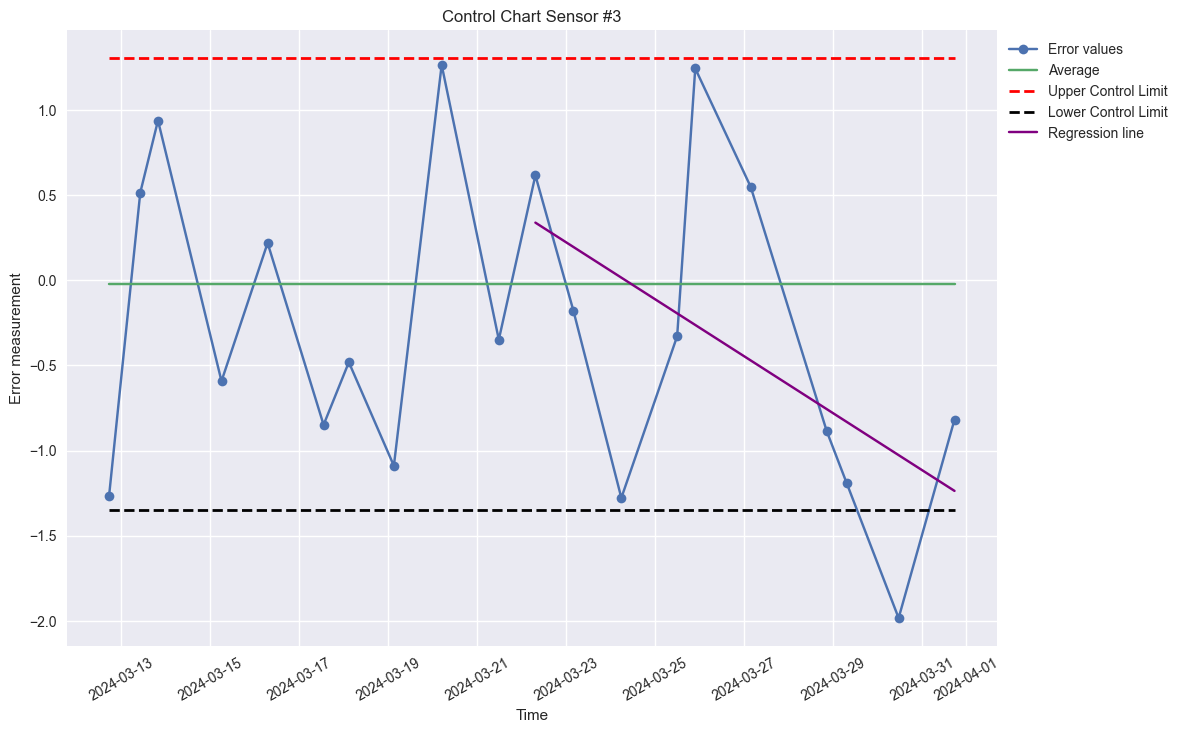

In [94]:
showControlCardWithRegressionLine()

### 6.4 - Règles utilisant le coefficiant directeur de la droite de regression

In [112]:
def simulate_regression(n):
  test_data = numpy.random.normal(size=1000000) # Generate test data
  results = []

  X = [i for i in range(n)]

  for i in range(0, len(test_data) - n + 1):
    Y = [element for element in test_data[i:i+n]]

    a, b = regressionLine(X, Y)
    results.append(abs(a))

  avg = getAverageFromData(results)
  stddev = getStddevFromData(results)

  print(avg, stddev)

  return results


results = simulate_regression(10)
threshold = 0.25
alert_count = 0

for result in results:
  if(result > threshold):
    alert_count += 1

p_value = alert_count / len(results)
print("L'alerte s'est déclenchée " + str(alert_count) + " fois sur " + str(len(results)) + ". Soit: " + str(p_value * 100) + "%")

0.08803629787685456 0.06658365735205511
L'alerte s'est déclenchée 23629 fois sur 999991. Soit: 2.3629212662913965%
